### Package Imports

In [1]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import sys
import warnings
warnings.filterwarnings('ignore')

init = time()

### Latexify for LaTeX ready plots

In [2]:
def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.33 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (5**.5-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': [r'\usepackage{gensymb}'],
              'axes.labelsize': 8, # fontsize for x and y labels (was 8)
              'axes.titlesize': 8,
              'font.size': 8, # was 8
              'legend.fontsize': 8, # was 8
              'xtick.labelsize': 7,
              'ytick.labelsize': 7,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

### Import kriging

In [3]:
from polire import Kriging

### Dataset loading

In [4]:
df = pd.read_csv("../../data/pm.csv.gz")
df.head(2)

,Date,Source,Site ID,POC,Daily Mean PM10 Concentration,UNITS,DAILY_AQI_VALUE,Site Name,DAILY_OBS_COUNT,PERCENT_COMPLETE,AQS_PARAMETER_CODE,AQS_PARAMETER_DESC,CBSA_CODE,CBSA_NAME,STATE_CODE,STATE,COUNTY_CODE,COUNTY,SITE_LATITUDE,SITE_LONGITUDE
0,01/11/1990,AQS,120111003,1,45,ug/m3 SC,42,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379
1,01/17/1990,AQS,120111003,1,21,ug/m3 SC,19,NaN,1,100.0,81102,PM10 Total 0-10um STP,33100.0,"Miami-Fort Lauderdale-West Palm Beach, FL",12,Florida,11,Broward,26.129531,-80.168379


In [5]:
tdf = df.drop(columns=[ 'Source', 
       'UNITS', 'DAILY_AQI_VALUE', 'Site Name', 'DAILY_OBS_COUNT',
        'AQS_PARAMETER_CODE', 'AQS_PARAMETER_DESC',
       'STATE_CODE', 'CBSA_CODE','CBSA_NAME', 'POC'
                ])

## REMOVE UNUSED STATES

In [6]:
tdf = tdf[tdf['STATE']!='Hawaii']
tdf = tdf[tdf['STATE']!='Alaska']

In [7]:
t1 = pd.concat([tdf[tdf['SITE_LONGITUDE']<-104.01], tdf[tdf['SITE_LONGITUDE']>-99.42]])

In [8]:
t1 = t1[t1['STATE']!='New Mexico']
t1 = t1[t1['STATE']!='Arizona']

# removed missippi

In [9]:
states = t1['STATE'].unique()
nw = ['Washington', 'Oregon', 'Wyoming','Idaho', 'Montana', 'Colorado','Utah','Nevada']
sc = ['California']
mw = ['West Virginia', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin']
se = ['Oklahoma','Florida', 'Alabama', 'Georgia',  'Tennessee', 'South Carolina', 'North Carolina', 'Virginia', 'Louisiana', 'Arkansas', 'Texas', 'Kentucky']
ne = ['Connecticut',
 'Delaware',
 'Maine',
 'Maryland',
 'Massachusetts',
 'New Hampshire',
 'New Jersey',
 'New York',
 'Pennsylvania',
 'Rhode Island',
 'Vermont','District Of Columbia'
]


In [10]:
nwdf = t1[np.isin(t1['STATE'], nw)]
mwdf = t1[np.isin(t1['STATE'], mw)]
sedf = t1[np.isin(t1['STATE'], se)]
nedf = t1[np.isin(t1['STATE'], ne)]
cal = t1[np.isin(t1['STATE'], ['California'])]
ncal = cal[cal['SITE_LATITUDE']>=34.81]
scal = cal[cal['SITE_LATITUDE']<34.81]
nwdf = pd.concat([nwdf, ncal])

## 5 Regions under consideration
1. Northwest = [Washington, Oregon and Wyoming along with Idaho, Montana]
2. South California = Everything in California at latitude less than 35.70
3. Midwest = [ Illinois, Indiana, Iowa, Kansas, Michigan, Minnesota, Missouri, Nebraska, North Dakota, Ohio, South Dakota, and Wisconsin]
4. Southeast = [Florida, Alabama, Georgia, Mississippi, Tennessee, South Carolina, North Carolina, Virginia, Louisiana, Arkansas, and Texas. Kentucky, Maryland]
5. Northeast = 


## VALIDATION OF THE DATA BEFORE USAGE

In [11]:
def func_select_11(df):
    t = df.groupby(['Date', 'Site ID', 'STATE', 'COUNTY_CODE','COUNTY']).mean()
    t = t.reset_index(None)
    t1 = t.groupby('Site ID').count()
    t11 = t.set_index(['Site ID'])
    t11 = t11[t1['Date']>11]
    t11 = t11.reset_index(None)
    return t11

* Industrial Midwest Annual
* Northeast Q2
* Northwest Q1
* Southern California Annual
* Southeast Q3

    if str1=='Industrial Midwest' or str1=='Northeast' or str1=='Southeast':
        nlags = 40
    else:
        nlags = 17


PM10- VALUES MEAN =  29.567450442142068


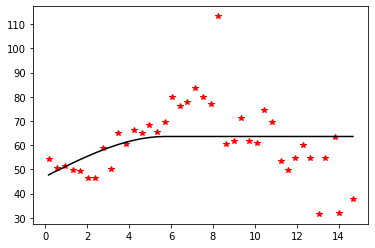

PM10- VALUES MEAN =  23.18392861890126


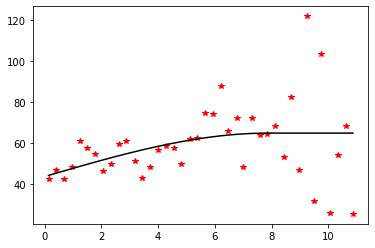

Q1
PM10- VALUES MEAN =  32.04300716806007


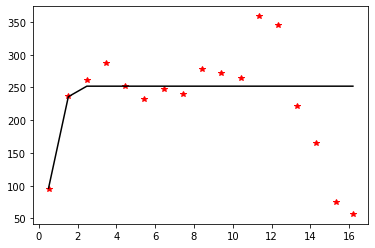

PM10- VALUES MEAN =  39.19482940832278


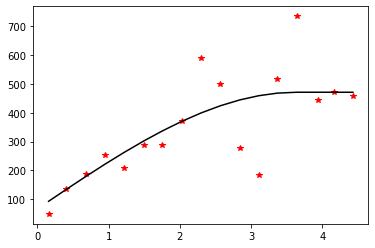

PM10- VALUES MEAN =  36.7580826019596


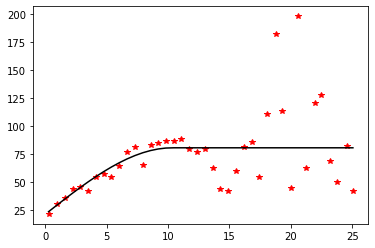

Kriging

In [12]:
# Industrial Midwest Annual
nlags = 40
annual_scal = mwdf.groupby('Site ID').mean()
annual_scal.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)
X = annual_scal[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = annual_scal['Daily Mean PM10 Concentration']
print("PM10- VALUES MEAN = ", y.values.mean())
X[:, 0] = X[:, 0] + 360
k1 = Kriging(plotting=True, variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k1.fit(X, y)

# Northeast Q2
nlags = 40
neq2 = nedf[(nedf['Date']>='04/01/1990').values & (nedf['Date']<='06/30/1990').values]
valid_scal_2 =  func_select_11(neq2)
valid_scal_2 = valid_scal_2.groupby('Site ID').mean()
valid_scal_2.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)
X = valid_scal_2[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = valid_scal_2['Daily Mean PM10 Concentration']
X[:, 0] = X[:, 0] + 360
print("PM10- VALUES MEAN = ", y.values.mean())
k2 = Kriging(plotting=True, variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k2.fit(X, y)

# Northwest Q1
nlags = 17
nwq1 = nwdf[nwdf['Date']<='03/31/1990']
valid_scal_1 =  func_select_11(nwq1)
valid_scal_1 = valid_scal_1.groupby('Site ID').mean()
valid_scal_1.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)
X = valid_scal_1[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = valid_scal_1['Daily Mean PM10 Concentration']
X[:, 0] = X[:, 0] + 360
print("Q1")
print("PM10- VALUES MEAN = ", y.values.mean())
k3 = Kriging(plotting=True, variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k3.fit(X, y)

# Southern California Annual
nlags = 17
annual_scal = scal.groupby('Site ID').mean()
annual_scal.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)
X = annual_scal[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = annual_scal['Daily Mean PM10 Concentration']
print("PM10- VALUES MEAN = ", y.values.mean())
X[:, 0] = X[:, 0] + 360
k4 = Kriging(plotting=True, variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k4.fit(X, y)

# Southeast Q3
nlags = 40
seq3 = sedf[(sedf['Date']>='07/01/1990').values & (sedf['Date']<='09/30/1990').values]
valid_scal_3 =  func_select_11(seq3)
valid_scal_3 = valid_scal_3.groupby('Site ID').mean()
valid_scal_3.drop(columns = ['COUNTY_CODE', 'PERCENT_COMPLETE'], inplace=True)
X = valid_scal_3[['SITE_LONGITUDE', 'SITE_LATITUDE']].values
y = valid_scal_3['Daily Mean PM10 Concentration']
print("PM10- VALUES MEAN = ", y.values.mean())
X[:, 0] = X[:, 0] + 360
k5 = Kriging(plotting=True, variogram_model='spherical', coordinate_type='Geographic', nlags=nlags)
k5.fit(X, y)


### Plotting


if str1=='Industrial Midwest' or str1=='Northeast' or str1=='Southeast':
    nlags = 40
else:
    nlags = 17

if str1 == "Northwest":
    xlim = (-10, 1010)
    ylim = None
if str1 == "Southern California":
    xlim = (-10, 410)
    ylim = None
if str1 == "Industrial Midwest":
    xlim = (-10, 1010)
    ylim = None
if str1 == "Northeast":
    xlim = (-10, 1010)
    ylim = None
if str1 == "Southeast":
#         pass
    xlim = (-10, 1010)
    ylim = (-10, 110)


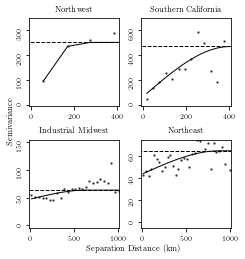

In [60]:
latexify(3.33,3.5)
title = "Northwest"
fig, axes = plt.subplots(2,2)
axes = axes.ravel()
ax = axes[0]

ax.scatter(k3.ok.lags * np.pi / 180 * 6371, k3.ok.semivariance, color='black', alpha=0.6, s=2)
ax.plot(
    k3.ok.lags * np.pi / 180 * 6371,
    k3.ok.variogram_function(k3.ok.variogram_model_parameters, k3.ok.lags),
    "k-", linewidth=1
)
ax.hlines(k3.ok.variogram_model_parameters[0]+k3.ok.variogram_model_parameters[2], 
          *ax.get_xlim(), linestyle='--', color='black', linewidth=1)
# ax.set_xlabel("Separation Distance (km)")
# ax.set_ylabel("Semivariance")
ax.set_title(title)
ax.set_xlim(-10, 410)
ax.set_ylim(-5, 350)
ax.tick_params(axis='both')
# ax.set_yticklabels(ax.get_yticks(), rotation = 90)
for tick in ax.get_yticklabels():
    tick.set_rotation(90)

ax.set_ylim(None)

title = "Southern California"
ax1 = axes[1]
ax1.scatter(k4.ok.lags * np.pi / 180 * 6371, k4.ok.semivariance, color='black', alpha=0.6, s=2)
ax1.plot(
    k4.ok.lags * np.pi / 180 * 6371,
    k4.ok.variogram_function(k4.ok.variogram_model_parameters, k4.ok.lags),
    "k-", linewidth=1
)
ax1.hlines(k4.ok.variogram_model_parameters[0]+k4.ok.variogram_model_parameters[2], 
           *ax1.get_xlim(), linestyle='--', color='black', linewidth=1)
# ax1.set_xlabel("Separation Distance (km)")
# ax1.set_ylabel("Semivariance")
ax1.set_title(title)
ax1.set_xlim(-10, 410)
ax1.set_ylim(-10, 700)
# ax1.set_ylim(None)
ax1.tick_params(axis='both')
# ax1.set_yticklabels(ax1.get_yticks(), rotation = 90)
for tick in ax1.get_yticklabels():
    tick.set_rotation(90)

title = "Industrial Midwest"
ax2 = axes[2]
ax2.scatter(k1.ok.lags * np.pi / 180 * 6371, k1.ok.semivariance, color='black', alpha=0.6, s=2)
ax2.plot(
    k1.ok.lags * np.pi / 180 * 6371,
    k1.ok.variogram_function(k1.ok.variogram_model_parameters, k1.ok.lags),
    "k-", linewidth=1
)
ax2.hlines(k1.ok.variogram_model_parameters[0]+k1.ok.variogram_model_parameters[2], 
           *ax2.get_xlim(), linestyle='--', color='black', linewidth=1)
# ax2.set_xlabel("Separation Distance (km)")
# ax2.set_ylabel("Semivariance")
ax2.set_title(title)
ax2.set_xlim(-10, 1010)
ax2.set_ylim(-5, 155)
ax2.tick_params(axis='both')
for tick in ax2.get_yticklabels():
    tick.set_rotation(90)

title = "Northeast"
ax3 = axes[3]
ax3.scatter(k2.ok.lags * np.pi / 180 * 6371, k2.ok.semivariance, color='black', alpha=0.6, s=2)
ax3.plot(
    k2.ok.lags * np.pi / 180 * 6371,
    k2.ok.variogram_function(k2.ok.variogram_model_parameters, k2.ok.lags),
    "k-", linewidth=1
)
ax3.hlines(k2.ok.variogram_model_parameters[0]+k2.ok.variogram_model_parameters[2], 
           *ax3.get_xlim(), linestyle='--', color='black', linewidth=1)
# ax3.set_xlabel("Separation Distance (km)")
# ax3.set_ylabel("Semivariance")
ax3.set_title(title)
ax3.set_xlim(-10, 1010)
ax3.set_ylim(-5, 75)
ax3.tick_params(axis='both')
for tick in ax3.get_yticklabels():
    tick.set_rotation(90)

# title = "Southeast"
# ax4 = plt.subplot(gs[14:, 3:8] )
# ax4.scatter(k5.ok.lags * np.pi / 180 * 6371, k5.ok.semivariance, color='black', alpha=0.6)
# ax4.plot(
#     k5.ok.lags * np.pi / 180 * 6371,
#     k5.ok.variogram_function(k5.ok.variogram_model_parameters, k5.ok.lags),
#     "k-",
# )
# ax4.set_xlabel("Separation Distance (km)")
# ax4.set_ylabel("Semivariance")
# ax4.set_title(title)
# ax4.set_xlim(-10, 2010)
# ax4.set_ylim(None)
# ax4.tick_params(axis='both')

fig.text(0, 0.42, 'Semivariance', rotation=90)
fig.text(0.33, 0, 'Separation Distance (km)')

fig.tight_layout()
plt.subplots_adjust(wspace=0.24)
plt.savefig('../../figures/variogram.pdf')

In [36]:
k1.ok.variogram_model_parameters.sum(),\
k2.ok.variogram_model_parameters.sum(),\
k3.ok.variogram_model_parameters.sum(),\
k4.ok.variogram_model_parameters.sum()

(69.32680686807555, 72.77970412436392, 253.84700960213613, 474.39670530906375)

In [51]:
k1.ok.delta

In [14]:
print('Finished in', (time()-init)/60, 'minutes')

Finished in 0.0671048124631246 minutes
